<a href="https://colab.research.google.com/github/sushmit86/Statiistical_rethinking_jax/blob/main/sushmit_05_geocentric_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
# Install packages that are not installed in colab
try:
  import google.colab
  !pip install watermark
  !pip install jaxopt
  !pip install networkx
  !pip install arviz
except:
  pass

In [147]:
#@title import library
import numpy as np
import scipy.stats as stats
import pandas as pd
# import daft
import networkx as nx
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp_jax
from collections import OrderedDict
tfd = tfp_jax.distributions
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import jaxopt
from jaxopt import ScipyMinimize
import arviz
import itertools
import collections
import arviz as az
key = jax.random.PRNGKey(42)

def marginal_test_results(model, results, nll,credib_interval = 0.89, num_of_samples = 10000):
  '''
  model: tfp model like
  results: results from optimizing
  nll: negative log likelihood function
  credib_interval: the interval we are interested in
  num_of_samples: number of samples we want to get from the posterior distribution
  '''
  key = jax.random.PRNGKey(42)
  inv_hessian_matrix = jnp.linalg.inv(jax.hessian(nll)(results.params))
  mean_list = results.params
  sd_list = jnp.diagonal(inv_hessian_matrix)**(1/2)
  low_credib_interval = (1 - credib_interval)/2
  high_credib_interval = 1 - low_credib_interval
  parameter_list = []
  normal_dist = tfp_jax.distributions.Normal(loc=mean_list,scale =  sd_list)
  for _parameter in model.parameters['model']:
    if isinstance(model.parameters['model'][_parameter],tfp_jax.distributions.Distribution):
      try:
        _shape = model.parameters['model'][_parameter].event_shape[0]
        parameter_list.extend([_parameter + '_' +str(i) for i in range(0, _shape)])
      except:
        parameter_list.append(_parameter)

  df_result = pd.DataFrame({'mean': mean_list,
                           'sd':sd_list,
                            'low': normal_dist.quantile(low_credib_interval),
                            'high':tfp_jax.distributions.Normal(loc=mean_list,scale =  sd_list).quantile(high_credib_interval) },
                           index = parameter_list)
  post_dist = tfp_jax.distributions.MultivariateNormalFullCovariance(
    loc=results.params,covariance_matrix=inv_hessian_matrix )
  post_samples = post_dist.sample( sample_shape=num_of_samples,seed=key)
  df_post_samples = pd.DataFrame(post_samples,columns = parameter_list)
  return df_result,inv_hessian_matrix,df_post_samples
credib_interval = 0.89

In [148]:
#@title 5.1
d = pd.read_csv('https://raw.githubusercontent.com/sushmit86/Statiistical_rethinking_jax/main/WaffleDivorce.csv',sep= ';')
d['A'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean())/d.MedianAgeMarriage.std()
d['D'] = (d.Divorce - d.Divorce.mean())/d.Divorce.std()
d.head()
A_arr = jnp.array(d.A)
D_arr = jnp.array(d.D)

In [149]:
#@title 5.2
d.MedianAgeMarriage.std()

1.2436303013880823

In [150]:
#@title 5.3
model5_1 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.Normal(loc=0.0,scale=0.2),
    bA = tfd.Normal(loc=0,scale=0.5),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda  alpha,bA,sigma: tfd.Deterministic(alpha + bA * A_arr),
    D = lambda mu,sigma: tfd.Sample(tfd.Normal(loc=mu,scale=sigma))
))
def nll5_1(parameters):
  samples = model5_1.sample(
      D = D_arr,
      alpha = parameters[0],
      bA = parameters[1],
      sigma = parameters[2],
      seed = jax.random.PRNGKey(42))
  return -1* model5_1.log_prob(samples)

x_arr =jnp.array([-2,2])

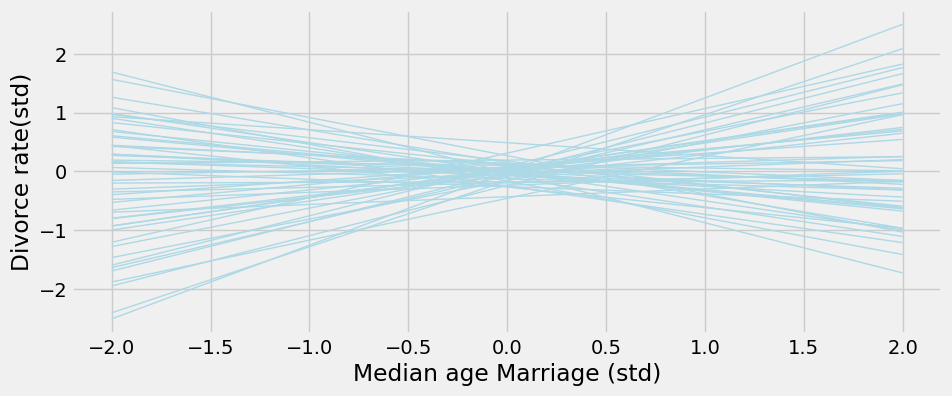

In [151]:
#@title 5.4
prior_samples =model5_1.sample(sample_shape= 50,seed = jax.random.PRNGKey(42))
fig, ax = plt.subplots(1,1,figsize=(10,4))
for _alpha,_bA in zip(prior_samples['alpha'],prior_samples['bA']):
  y_arr = _alpha + _bA * x_arr
  ax.plot(x_arr,y_arr,color = 'lightblue',linewidth=1)
ax.set_xlabel('Median age Marriage (std)')
ax.set_ylabel('Divorce rate(std)')
fig.show()

In [152]:
optimize_fn = ScipyMinimize(fun= nll5_1,method = 'L-BFGS-B' )
alpha_start = model5_1.parameters['model']['alpha'].mean()
bA_start = model5_1.parameters['model']['bA'].mean()
sigma_start = model5_1.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params=jnp.array([alpha_start,bA_start,sigma_start]))
df_result,cov_matrix,df_post_samples_m_5_1 = marginal_test_results(model5_1,results,nll5_1)
df_result.round(3)

,mean,sd,low,high
alpha,0.000,0.097,-0.156,0.156
bA,-0.568,0.110,-0.744,-0.393
sigma,0.788,0.078,0.664,0.913


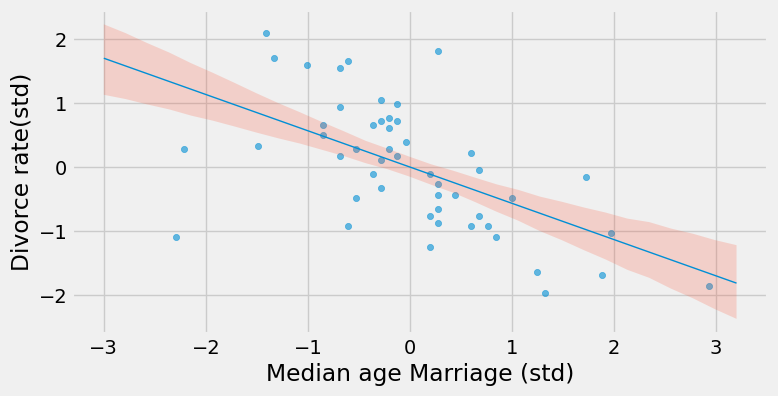

In [153]:
#@title 5.5
A_seq = np.linspace(-3,3.2,30)
get_mu_lower = lambda _A: arviz.hdi(np.array(df_post_samples_m_5_1.alpha + df_post_samples_m_5_1.bA * _A),hdi_prob = credib_interval)[0]
get_mu_upper = lambda _A: arviz.hdi(np.array(df_post_samples_m_5_1.alpha + df_post_samples_m_5_1.bA * _A),hdi_prob = credib_interval)[1]
vfunc_lower = np.vectorize(get_mu_lower)
vfunc_upper = np.vectorize(get_mu_upper)
mu_lower=vfunc_lower(A_seq)
mu_upper=vfunc_upper(A_seq)
mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['bA','mean'] * A_seq

fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.scatter(d.A,d.D,alpha=0.6,s=20)
axs.plot(A_seq, mean_mu_pred,linewidth=1.0)
axs.fill_between(A_seq, mu_lower,mu_upper, alpha=0.2)
axs.set_xlabel('Median age Marriage (std)')
axs.set_ylabel('Divorce rate(std)')
fig.show()

In [154]:
# @title 5.6
d['M'] = (d.Marriage - d.Marriage.mean())/d.Marriage.std()
M_arr = jnp.array(d.M)
model5_2 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.Normal(loc=0.0,scale=0.2),
    bM = tfd.Normal(loc=0,scale=0.5),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda  alpha,bM,sigma: tfd.Deterministic(alpha + bM * M_arr),
    D = lambda mu,sigma: tfd.Sample(tfd.Normal(loc=mu,scale=sigma))
    ))
def nll5_2(parameters):
  samples = model5_2.sample(
      D = D_arr,
      alpha = parameters[0],
      bM = parameters[1],
      sigma = parameters[2],
      seed = jax.random.PRNGKey(42))
  return -1* model5_2.log_prob(samples)

In [155]:
optimize_fn = ScipyMinimize(fun= nll5_2,method = 'L-BFGS-B' )
alpha_start = model5_2.parameters['model']['alpha'].mean()
bM_start = model5_2.parameters['model']['bM'].mean()
sigma_start = model5_2.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params=jnp.array([alpha_start,bM_start,sigma_start]))
df_result,cov_matrix,df_post_samples_m_5_2 = marginal_test_results(model5_2,results,nll5_2)
df_result.round(3)

,mean,sd,low,high
alpha,0.00,0.108,-0.173,0.173
bM,0.35,0.126,0.149,0.551
sigma,0.91,0.090,0.767,1.054


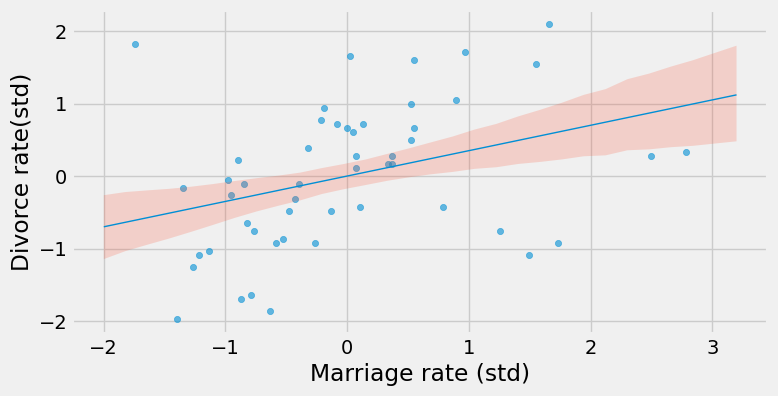

In [156]:
M_seq = np.linspace(-2,3.2,30)
get_mu_lower = lambda _M: arviz.hdi(np.array(df_post_samples_m_5_2.alpha + df_post_samples_m_5_2.bM * _M),hdi_prob = credib_interval)[0]
get_mu_upper = lambda _M: arviz.hdi(np.array(df_post_samples_m_5_2.alpha + df_post_samples_m_5_2.bM * _M),hdi_prob = credib_interval)[1]
vfunc_lower = np.vectorize(get_mu_lower)
vfunc_upper = np.vectorize(get_mu_upper)
mu_lower=vfunc_lower(M_seq)
mu_upper=vfunc_upper(M_seq)
mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['bM','mean'] * M_seq

fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.scatter(d.M,d.D,alpha=0.6,s=20)
axs.plot(M_seq, mean_mu_pred,linewidth=1.0)
axs.fill_between(M_seq, mu_lower,mu_upper, alpha=0.2)
axs.set_xlabel('Marriage rate (std)')
axs.set_ylabel('Divorce rate(std)')
fig.show()

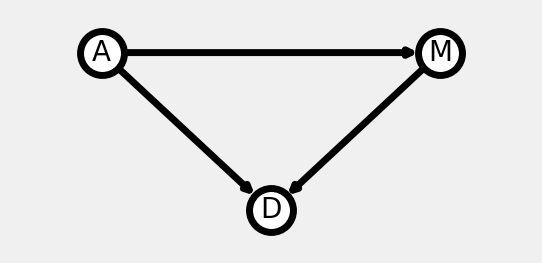

In [157]:
#@title 5.7
dag5_1 = nx.DiGraph()
dag5_1.add_edges_from([("A", "D"), ("A", "M"), ("M", "D")])
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
fig,axs = plt.subplots(1,1,figsize=(6,3))
options = {
    "font_size": 20,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw_networkx(dag5_1,coordinates, arrows=True,ax=axs,**options)
plt.gca().invert_yaxis()
axs.margins(0.20)
plt.axis("off")
plt.show()

In [158]:
#@title 5.8
DMA_dag2 = nx.DiGraph()
DMA_dag2.add_edges_from([("A", "D"), ("A", "M")])
conditional_independencies = collections.defaultdict(list)
for edge in itertools.combinations(sorted(DMA_dag2.nodes), 2):
    remaining = sorted(set(DMA_dag2.nodes) - set(edge))
    for size in range(len(remaining) + 1):
        for subset in itertools.combinations(remaining, size):
            if any(cond.issubset(set(subset)) for cond in conditional_independencies[edge]):
                continue
            if nx.is_d_separator(DMA_dag2, {edge[0]}, {edge[1]}, set(subset)):
                conditional_independencies[edge].append(set(subset))
                print(f"{edge[0]} _||_ {edge[1]}" + (f" | {' '.join(subset)}" if subset else ""))


D _||_ M | A


In [159]:
#@title 5.9
DMA_dag1 = nx.DiGraph()
DMA_dag1.add_edges_from([("A", "D"), ("A", "M"), ("M", "D")])
conditional_independencies = collections.defaultdict(list)
for edge in itertools.combinations(sorted(DMA_dag1.nodes), 2):
    remaining = sorted(set(DMA_dag1.nodes) - set(edge))
    for size in range(len(remaining) + 1):
        for subset in itertools.combinations(remaining, size):
            if any(cond.issubset(set(subset)) for cond in conditional_independencies[edge]):
                continue
            if nx.d_separated(DMA_dag1, {edge[0]}, {edge[1]}, set(subset)):
                conditional_independencies[edge].append(set(subset))
                print(f"{edge[0]} _||_ {edge[1]}" + (f" | {' '.join(subset)}" if subset else ""))

<ipython-input-159-f5ce2a2a0843>:11: DeprecationWarning: d_separated is deprecated and will be removed in NetworkX v3.5.Please use `is_d_separator(G, x, y, z)`.
  if nx.d_separated(DMA_dag1, {edge[0]}, {edge[1]}, set(subset)):


In [160]:
#@title 5.10
model5_3 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.Normal(loc=0.0,scale=0.2),
    bA = tfd.Normal(loc=0,scale=0.5),
    bM = tfd.Normal(loc=0,scale=0.5),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda alpha,bA,bM: tfd.Deterministic(alpha + bM * M_arr + bA * A_arr),
    D = lambda mu,sigma: tfd.Normal(mu,sigma)
))
def nll5_3(parameters):
  samples = model5_3.sample(
      D = D_arr,
      alpha = parameters[0],
      bA = parameters[1],
      bM = parameters[2],
      sigma = parameters[3],
      seed = jax.random.PRNGKey(42))
  return -1* model5_3.log_prob(samples)

optimize_fn = ScipyMinimize(fun= nll5_3,method = 'L-BFGS-B' )
alpha_start = model5_3.parameters['model']['alpha'].mean()
bA_start = model5_3.parameters['model']['bA'].mean()
bM_start = model5_3.parameters['model']['bM'].mean()
sigma_start = model5_3.parameters['model']['sigma'].mean()

results = optimize_fn.run(init_params=jnp.array([alpha_start,bA_start,bM_start,sigma_start]))
df_result,cov_matrix,df_post_samples_m_5_3 = marginal_test_results(model5_3,results,nll5_3)
df_result.round(3)

,mean,sd,low,high
alpha,0.000,0.097,-0.155,0.155
bA,-0.613,0.151,-0.855,-0.372
bM,-0.065,0.151,-0.306,0.176
sigma,0.785,0.078,0.661,0.910


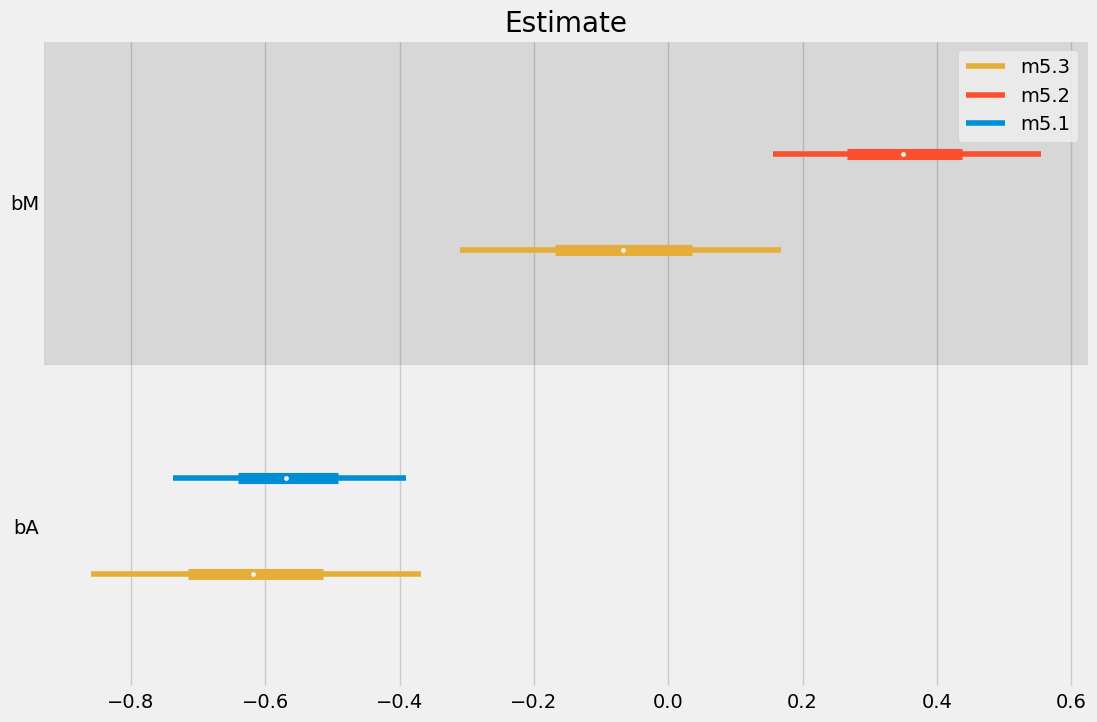

In [161]:
#@title 5.11
fig,ax = plt.subplots(1,1,figsize=(12,8))
az.plot_forest(
data = [{"bA":df_post_samples_m_5_1['bA'].values},{"bM":df_post_samples_m_5_2['bM'].values},
        {"bA": df_post_samples_m_5_3['bA'], "bM":df_post_samples_m_5_3['bM'].values }],
hdi_prob=0.89,
model_names=["m5.1","m5.2","m5.3"],
ax=ax,
)
ax.set_title('Estimate')
plt.show()

In [162]:
#@title 5.12 [complete the simulation]
age = stats.norm.rvs(size= 100)
marriage = stats.norm.rvs(loc = -age)
div = stats.norm.rvs(loc= age)

In [163]:
#@title 5.13
model5_4 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.Normal(loc=0.0,scale=0.2),
    beta = tfd.Normal(loc=0,scale=0.5),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda alpha,beta: tfd.Deterministic(alpha + beta * A_arr),
    M = lambda mu,sigma: tfd.Sample(tfd.Normal(loc=mu,scale=sigma))
))
def nll5_4(parameters):
  samples = model5_4.sample(
      M = M_arr,
      alpha = parameters[0],
      beta = parameters[1],
      sigma = parameters[2],
      seed = jax.random.PRNGKey(42))
  return -1* model5_4.log_prob(samples)

optimize_fn = ScipyMinimize(fun= nll5_4,method = 'L-BFGS-B' )
alpha_start = model5_4.parameters['model']['alpha'].mean()
beta_start = model5_4.parameters['model']['beta'].mean()
sigma_start = model5_4.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params=jnp.array([alpha_start,beta_start,sigma_start]))
df_result,cov_matrix,df_post_samples_m_5_4 = marginal_test_results(model5_4,results,nll5_4)
df_result.round(3)

,mean,sd,low,high
alpha,-0.000,0.087,-0.139,0.139
beta,-0.695,0.096,-0.848,-0.542
sigma,0.682,0.068,0.574,0.790


In [164]:
#@title 5.14
mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['beta','mean'] * A_arr
mu_resid = d.M - mean_mu_pred
print(mu_resid.values)

[-3.98568004e-01  1.07272577e+00 -9.29193497e-02  6.75274014e-01
  1.49753749e-01  6.93786621e-01  7.00570941e-02  1.09123850e+00
  1.40117598e+00 -6.26637280e-01  4.36889768e-01  1.73277497e+00
 -9.72081423e-02 -5.44825792e-02 -2.80434549e-01 -4.10407782e-04
 -6.58832788e-02 -1.51280284e-01  4.19352204e-02 -1.54819787e+00
  2.18429625e-01  2.30536222e-01 -7.58288801e-01 -1.13011622e+00
 -3.56222391e-01 -6.52261853e-01 -6.22728467e-01 -5.00686169e-01
 -4.82173532e-01 -4.79676247e-01 -6.65890500e-02  4.37975526e-01
 -1.22452728e-01  1.31290162e+00 -7.08831310e-01  4.65497971e-02
 -3.49816263e-01 -6.30546212e-01 -1.47697210e-01 -3.37003946e-01
 -2.57307321e-01 -6.65074110e-01 -1.12137794e-01  9.59207058e-01
 -5.05300760e-01  2.94923276e-01  2.52577662e-01 -3.95529866e-02
 -6.29840374e-01  1.75161338e+00]


In [165]:
df_post_samples_m_5_3

,alpha,bA,bM,sigma
0,-0.008786,-0.745718,-0.111983,0.826510
1,0.120890,-0.855759,-0.338505,0.796518
2,0.068269,-0.642591,0.117749,0.900076
3,0.056068,-0.719241,-0.329367,0.903853
4,-0.140880,-0.661773,-0.093419,0.829129
...,...,...,...,...
9995,-0.095913,-0.573750,-0.038975,0.758261
9996,-0.027727,-0.626827,0.189826,0.953962
9997,-0.024114,-0.845804,-0.222254,0.878387
9998,0.122582,-0.818949,-0.258265,0.744615


In [166]:
#@title 5.15
post_samples_m_5_3_array = df_post_samples_m_5_3.to_numpy()
post_samples_m_5_3_array
fn_mu_5_3 = lambda _samples,_A,_M: _samples[:,0] + _samples[:,1] * _A + _samples[:,2] * _M
sampled_mu = jax.vmap(fn_mu_5_3,in_axes=(None,0,0),out_axes=1)(post_samples_m_5_3_array,A_arr,M_arr)
mu_PI = np.apply_along_axis(arviz.hdi, axis=0, arr=np.array(sampled_mu),hdi_prob=credib_interval).T
mu_mean = np.apply_along_axis(np.mean, axis=0, arr=np.array(sampled_mu))
fn_sample_D = lambda _mu,_sigma: tfd.Normal(loc=_mu,scale=_sigma).sample(seed = key)
D_sim = jax.vmap(fn_sample_D,in_axes=(1,None),out_axes=1)(sampled_mu,post_samples_m_5_3_array[:,3])
D_PI = np.apply_along_axis(arviz.hdi, axis=0, arr=np.array(D_sim),hdi_prob=credib_interval).T

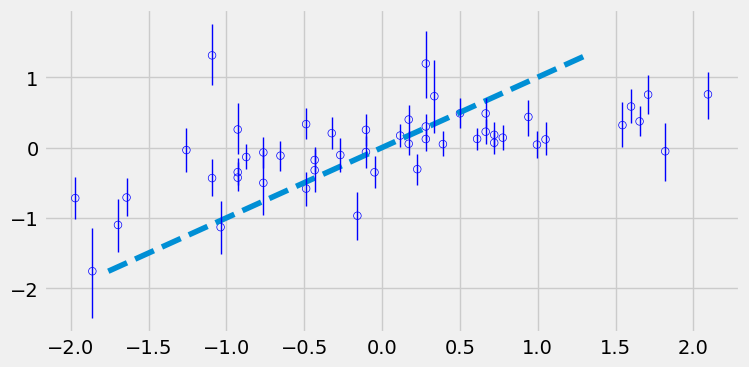

In [167]:
#@title 5.16
mu_mean
fig,axs = plt.subplots(1,1,figsize=(8,4))
axs.scatter(d.D,mu_mean,s=30, facecolors='none', edgecolors='b')
fig.show()

x = np.linspace(mu_mean.min(), mu_mean.max(), 101)
axs.plot(x, x, "--")
for i in range(d.shape[0]):
    plt.plot([d.D[i]] * 2, mu_PI[i],'b',lw=1)
fig = plt.gcf();
